In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_model(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

def getDescriptorNames(mol, missingVal=None):
    """calculate the full list of descriptors for a molecule

    missingVal is used if the descriptor cannot be calculated
    """
    desc_list = []

    for nm, fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            nm=None
        desc_list.append(nm)
    return desc_list

def get_descriptors(df):
    solvent_descriptors = [
        list(getDescriptorNames(Chem.MolFromSmiles(smile)))
        for smile in df["Solvent_SMILES"]
    ]
    solute_descriptors = [
        list(getDescriptorNames(Chem.MolFromSmiles(smile)))
        for smile in df["Solute_SMILES"]
    ]
    
    X = np.concatenate([solvent_descriptors, solute_descriptors], axis=1)

    return X, solvent_descriptors, solute_descriptors


In [4]:
model_path = '../models/XGBoost-conc_descirptors-y_standard.pkl'
csv_file = "../data/raw/database_IAC_ln_clean.csv"

model=load_model(model_path)
df = pd.read_csv(csv_file)

In [5]:
total_desc, solvent_desc, solute_desc = get_descriptors(df)
model_importance = model.feature_importances_

len(solvent_desc[0]), len(solute_desc[0]), len(total_desc[0]), len(model_importance)

(210, 210, 420, 420)

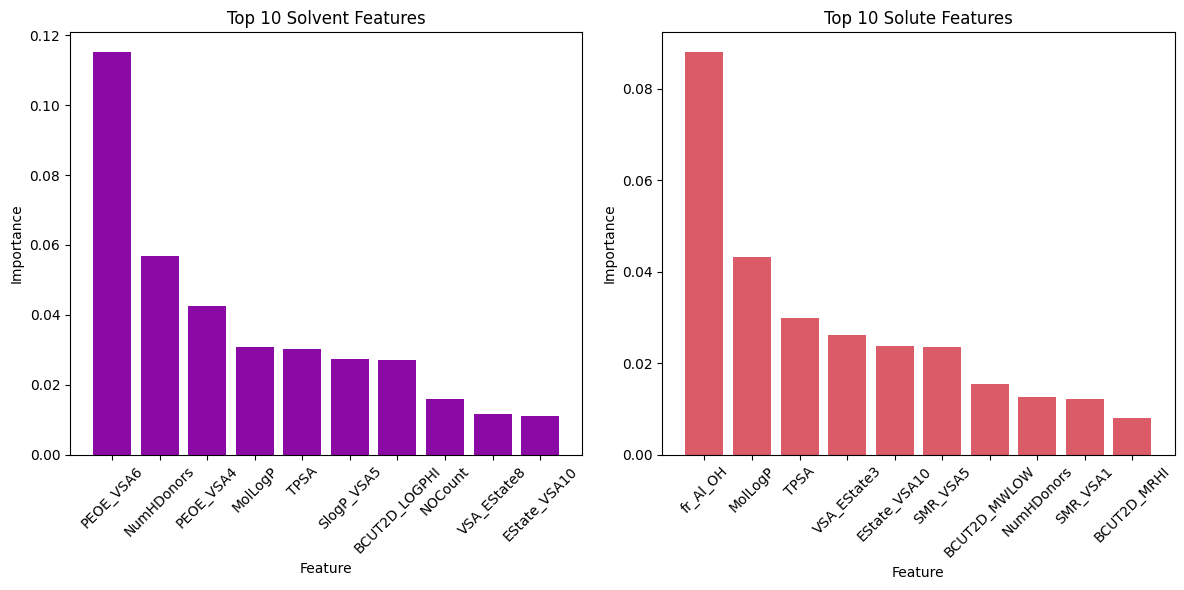

In [10]:
solvent_features_len = len(solvent_desc[0])
solute_features_len = len(solute_desc[0])

solvent_importance_dict = dict(zip(total_desc[0][:solvent_features_len], model_importance[:solvent_features_len]))
solute_importance_dict = dict(zip(total_desc[0][solvent_features_len:], model_importance[solvent_features_len:]))

# Sort the dictionaries based on importance values in descending order
sorted_solvent_features = sorted(solvent_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_solute_features = sorted(solute_importance_dict.items(), key=lambda x: x[1], reverse=True)

N = 10  # Change this to the desired number of top features to display

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the top N solvent features
solvent_features = [feature for feature, _ in sorted_solvent_features[:N]]
solvent_importances = [importance for _, importance in sorted_solvent_features[:N]]
ax1.bar(solvent_features, solvent_importances, color = '#8B0AA5')
ax1.set_title(f'Top {N} Solvent Features')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Importance')
ax1.tick_params(axis='x', rotation=45)

# Plot the top N solute features
solute_features = [feature for feature, _ in sorted_solute_features[:N]]
solute_importances = [importance for _, importance in sorted_solute_features[:N]]
ax2.bar(solute_features, solute_importances, color = '#DB5B68')
ax2.set_title(f'Top {N} Solute Features')
ax2.set_xlabel('Feature')
ax2.set_ylabel('Importance')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('feature_importance.pdf')
plt.show()